<a href="https://colab.research.google.com/github/Riwaskarki/Belly_button/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import all the dependencies for ML project
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Data visualization
import psycopg2  # PostgreSQL adapter
from psycopg2 import sql  # SQL queries
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Preprocessing
from xgboost import XGBClassifier  # XGBoost classifier
from sklearn.model_selection import train_test_split  # Train-test split
from sklearn.metrics import classification_report, accuracy_score  # Metrics
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.utils import resample  # Resampling utilities
from imblearn.over_sampling import SMOTE  # Handle imbalanced data
import joblib  # Model saving
from skl2onnx import convert_sklearn  # Convert to ONNX
from skl2onnx.common.data_types import FloatTensorType  # ONNX types
import onnx  # ONNX support
import pickle  # Object serialization
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
# Ensure skl2onnx is installed for model conversion to ONNX format.
!pip install skl2onnx

## The Database is stored in a postgres server in AWS, so any one can connect to the database with the credentials.

In [3]:
# Define the connection parameters
host = 'database-1.cxu0eg8y6y4k.ap-southeast-2.rds.amazonaws.com'
database = 'Finance_db'
user = 'postgres'
password = 'Radin5286'
port = '5432'

In [4]:
# Establish the connection
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password,
        port=port
    )
    print("Connection successful!")
except Exception as e:
    print(f"Error: {e}")

Connection successful!


In [5]:
query = """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
      AND table_type = 'BASE TABLE';
    """

    # Execute the query and load into a DataFrame
df_tables = pd.read_sql(query, conn)

    # Display the DataFrame containing table names
print(df_tables)


              table_name
0  classification_report
1                finance


In [6]:
query = "SELECT * FROM finance;"

In [7]:
finance_df = pd.read_sql(query, conn)
finance_df.head(2)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0


In [8]:
conn.close()

In [9]:
finance_df.dtypes
#Checking dtypes.

,0
fraud_bool,int64
income,float64
name_email_similarity,float64
prev_address_months_count,int64
current_address_months_count,int64
customer_age,int64
days_since_request,float64
intended_balcon_amount,float64
payment_type,object
zip_count_4w,int64


In [10]:
finance_df['fraud_bool'].unique()

array([0, 1])

In [16]:
Class_count=finance_df['fraud_bool'].value_counts()
Class_count

,count
fraud_bool,
0,988971
1,11029


### Plotting the Pie chart to see the class imbalance.0 represents non-fraud and 1 represents fraud.

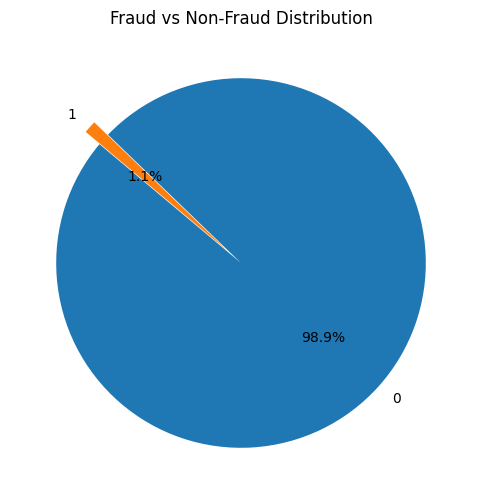

In [17]:
plt.figure(figsize=(8, 6))
explode = [0, 0.1]  # Explode the 'Fraud' segment
plt.pie(Class_count, labels=Class_count.index, autopct='%1.1f%%', explode=explode, startangle=140)

# Customizing the plot
plt.title('Fraud vs Non-Fraud Distribution')
plt.show()

In [12]:
finance_df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [14]:

 correlation_matrix = finance_df[['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
        'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
        'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free',
        'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
        'has_other_cards', 'proposed_credit_limit', 'foreign_request',
        'session_length_in_minutes', 'keep_alive_session',
        'device_distinct_emails_8w', 'device_fraud_count', 'month']].corr()
# Looking at the correlation to see which features are more important.

correlation_matrix

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
fraud_bool,1.000000,0.045079,-0.036720,-0.026031,0.033701,0.062959,0.000567,-0.024524,0.005212,-0.016892,...,-0.013180,-0.003222,-0.035156,0.068907,0.016885,0.008999,-0.050296,0.035704,NaN,0.013250
income,0.045079,1.000000,-0.038519,0.018209,-0.036985,0.125822,-0.015877,0.059046,-0.080581,-0.096431,...,0.014979,-0.004514,0.086861,0.108868,0.011452,-0.055430,-0.043584,-0.009992,NaN,0.116479
name_email_similarity,-0.036720,-0.038519,1.000000,-0.018186,0.050305,-0.048902,-0.007736,0.029040,0.025114,0.024881,...,0.008966,-0.006351,0.011021,0.073159,-0.015224,0.005998,0.014342,-0.017804,NaN,-0.042949
prev_address_months_count,-0.026031,0.018209,-0.018186,1.000000,-0.271730,-0.069178,0.078107,-0.009428,-0.029638,-0.001265,...,0.004757,-0.045550,-0.042949,-0.028474,0.019242,0.051425,0.031672,0.011924,NaN,-0.001793
current_address_months_count,0.033701,-0.036985,0.050305,-0.271730,1.000000,0.142863,-0.057836,0.057601,0.047286,0.027508,...,-0.088268,0.071997,0.060732,0.130594,-0.012355,-0.033574,-0.050539,-0.000760,NaN,-0.024541
customer_age,0.062959,0.125822,-0.048902,-0.069178,0.142863,1.000000,-0.035999,-0.013000,-0.014176,-0.022063,...,-0.147098,0.012907,0.108743,0.148857,-0.001606,0.025049,-0.024272,0.025709,NaN,0.005694
days_since_request,0.000567,-0.015877,-0.007736,0.078107,-0.057836,-0.035999,1.000000,0.019782,0.000249,0.027968,...,0.005130,-0.027460,-0.048861,-0.068670,0.001066,0.049613,0.000337,0.009025,NaN,-0.017938
intended_balcon_amount,-0.024524,0.059046,0.029040,-0.009428,0.057601,-0.013000,0.019782,1.000000,0.002251,0.042849,...,0.038625,0.178374,0.096676,0.057860,0.007933,0.022811,-0.020689,-0.019910,NaN,-0.043070
zip_count_4w,0.005212,-0.080581,0.025114,-0.029638,0.047286,-0.014176,0.000249,0.002251,1.000000,0.142372,...,0.012122,0.053637,-0.015015,-0.011651,0.017212,0.039687,0.022283,0.020550,NaN,-0.287203
velocity_6h,-0.016892,-0.096431,0.024881,-0.001265,0.027508,-0.022063,0.027968,0.042849,0.142372,1.000000,...,-0.010751,0.014874,-0.007049,-0.025005,-0.000450,0.054491,0.002797,0.030030,NaN,-0.409148


#### Plotting the heatmap.

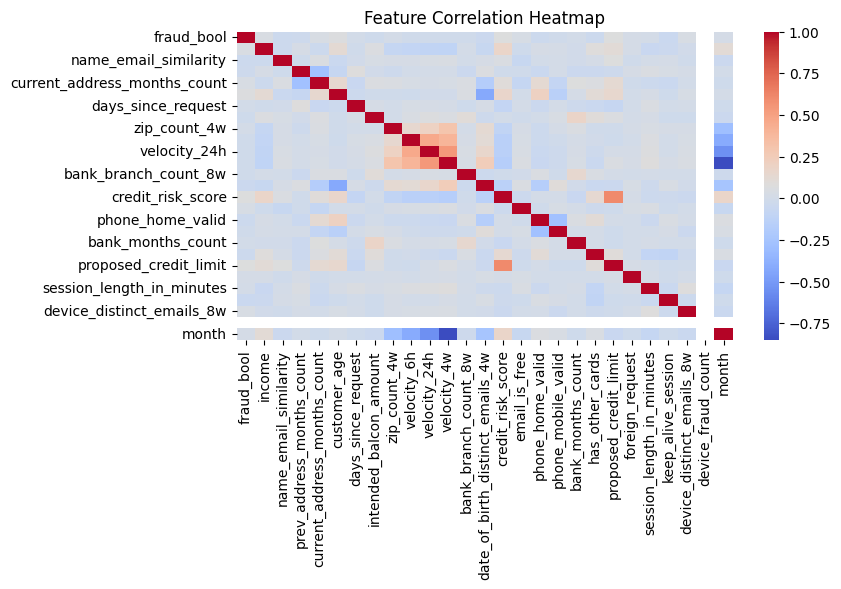

In [15]:
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()

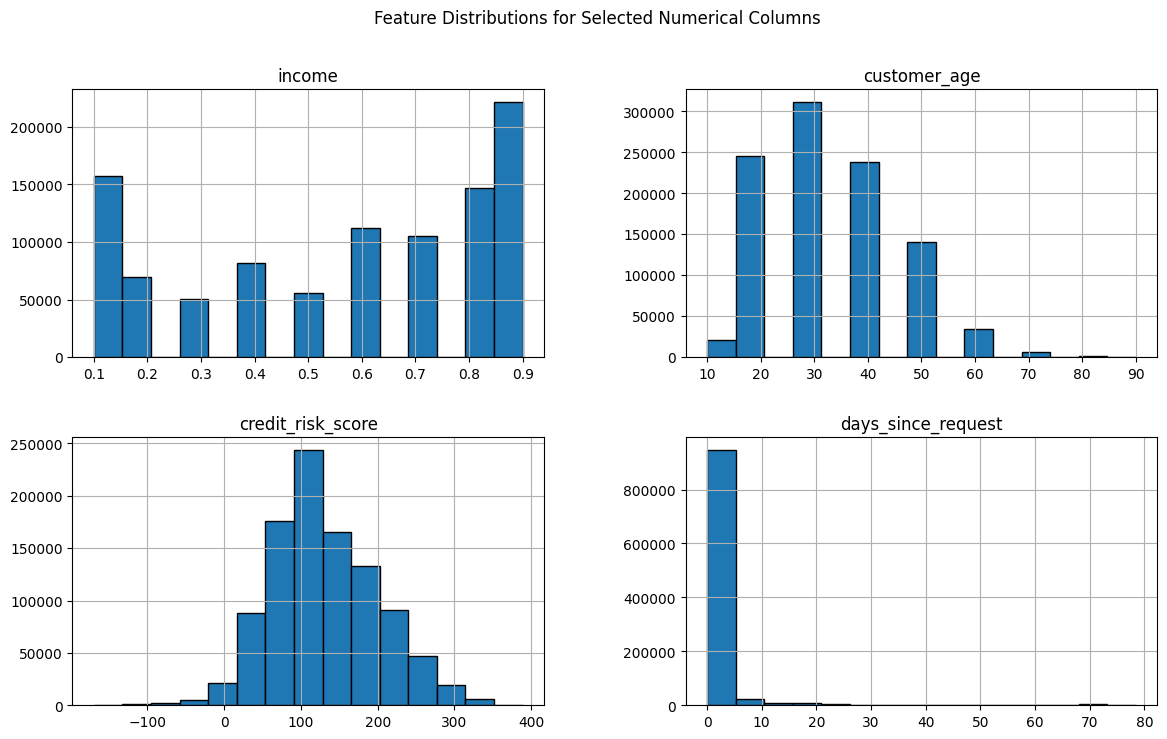

In [32]:
numeric_features = ['income', 'customer_age', 'credit_risk_score', 'days_since_request']
finance_df[numeric_features].hist(bins=15, figsize=(14, 8), layout=(2, 2), edgecolor='black')
plt.suptitle("Feature Distributions for Selected Numerical Columns")
plt.show()

In [18]:
# looking for the null values in a data.
finance_df.isnull().sum()

,0
fraud_bool,0
income,0
name_email_similarity,0
prev_address_months_count,0
current_address_months_count,0
customer_age,0
days_since_request,0
intended_balcon_amount,0
payment_type,0
zip_count_4w,0


In [ ]:
# saving the dataframe to csv in local storage.
finance_df.to_csv('finance.csv')

In [19]:
finance_df.head(10)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
5,0,0.6,0.294840,-1,369,30,0.024232,-1.232556,AD,1204,...,0,200.0,0,INTERNET,6.987316,linux,1,1,0,0
6,0,0.2,0.773085,22,4,40,0.006919,-0.544676,AB,1998,...,0,200.0,0,INTERNET,28.199923,x11,1,1,0,0
7,0,0.8,0.153880,-1,103,40,0.045122,-1.101184,AB,1548,...,1,200.0,0,INTERNET,11.234264,other,1,1,0,0
8,0,0.3,0.523655,21,2,30,0.035206,-0.955737,AB,1781,...,0,200.0,0,INTERNET,5.329387,other,1,1,0,0
9,0,0.8,0.834475,-1,134,20,0.017245,-1.356393,AD,3113,...,0,1500.0,0,INTERNET,4.103970,other,1,1,0,0


In [20]:
finance_df['payment_type'].unique()

array(['AA', 'AD', 'AB', 'AC', 'AE'], dtype=object)

In [21]:
finance_df['employment_status'].unique()

array(['CB', 'CA', 'CC', 'CF', 'CD', 'CE', 'CG'], dtype=object)

In [22]:
finance_df['housing_status'].unique()

array(['BC', 'BE', 'BD', 'BA', 'BB', 'BF', 'BG'], dtype=object)

In [23]:
finance_df['source'].unique()

array(['INTERNET', 'TELEAPP'], dtype=object)

In [24]:
finance_df['device_os'].unique()

array(['linux', 'other', 'windows', 'x11', 'macintosh'], dtype=object)

In [25]:
# One-hot encoding 'employment_status'
finance_df1 = pd.get_dummies(finance_df, columns=['employment_status','payment_type','housing_status','device_os'], drop_first=True)
# drop_first=True prevents multicollinearity by dropping one category


In [26]:
finance_df1.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,...,False,True,False,False,False,False,False,False,False,False
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,...,False,True,False,False,False,False,False,True,False,False
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,...,False,True,False,False,False,False,False,False,True,False
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,...,False,True,False,False,False,False,False,False,False,False
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,...,False,True,False,False,False,False,False,True,False,False


In [27]:
# Example: Label encoding the 'payment_type' column
label_encoder = LabelEncoder()
finance_df1['source'] = label_encoder.fit_transform(finance_df1['source'])


In [28]:
finance_df1.dtypes

,0
fraud_bool,int64
income,float64
name_email_similarity,float64
prev_address_months_count,int64
current_address_months_count,int64
customer_age,int64
days_since_request,float64
intended_balcon_amount,float64
zip_count_4w,int64
velocity_6h,float64


### After the optimisation and few tries we came up with this as a final model. The optimisation notebook can be found in a repo.

In [29]:
# Count the number of instances for each class
class_counts = finance_df1['fraud_bool'].value_counts()

# Determine the number of instances for the minority class (1s)
num_minority = class_counts.min()

# Separate majority and minority classes
df_majority = finance_df1[finance_df1['fraud_bool'] == 0]
df_minority = finance_df1[finance_df1['fraud_bool'] == 1]

# Randomly undersample the majority class
df_majority_undersampled = resample(df_majority,
                                    replace=False,  # do not want to replace
                                    n_samples=num_minority,  # match minority class
                                    random_state=42)  # reproducible results

# Combine undersampled majority class with original minority class
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the new DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target variable
X = df_balanced.drop('fraud_bool', axis=1)  # Features
y = df_balanced['fraud_bool']  # Target variable

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Filter features based on the provided names
selected_features = [
    'current_address_months_count',
    'credit_risk_score',
    'device_os_windows',
    'name_email_similarity',
    'intended_balcon_amount',
    'income',
    'days_since_request',
    'session_length_in_minutes',
    'velocity_24h',
    'velocity_6h',
    'device_fraud_count',
    'bank_branch_count_8w',
    'bank_months_count',
    'customer_age',
    'has_other_cards',
]

# Select only the filtered features
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model with balanced class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      3335
           1       0.76      0.75      0.75      3283

    accuracy                           0.76      6618
   macro avg       0.76      0.76      0.76      6618
weighted avg       0.76      0.76      0.76      6618



In [30]:
print(pd.Series(y_train).value_counts())

fraud_bool
1    7746
0    7694
Name: count, dtype: int64


In [31]:
onnx_filename = 'model.onnx'
input_dim = X_train_scaled.shape[1]

# Convert the model to ONNX format and save it
try:
    onnx_model = convert_sklearn(model, initial_types=[('input', FloatTensorType([None, input_dim]))], target_opset=13)
    with open(onnx_filename, 'wb') as file:
        file.write(onnx_model.SerializeToString())
    print(f"Model saved to {onnx_filename}")
except Exception as e:
    print(f"Error converting or saving model: {e}")

Model saved to model.onnx


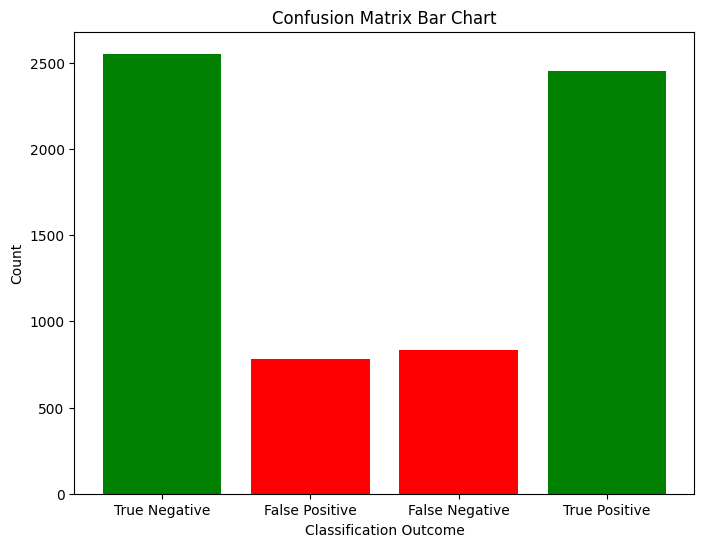

In [37]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Flatten the confusion matrix and create a bar chart
conf_values = conf_matrix.ravel()

plt.figure(figsize=(8, 6))
plt.bar(conf_labels, conf_values, color=['green', 'red', 'red', 'green'])
plt.xlabel('Classification Outcome')
plt.ylabel('Count')
plt.title('Confusion Matrix Bar Chart')
plt.show()

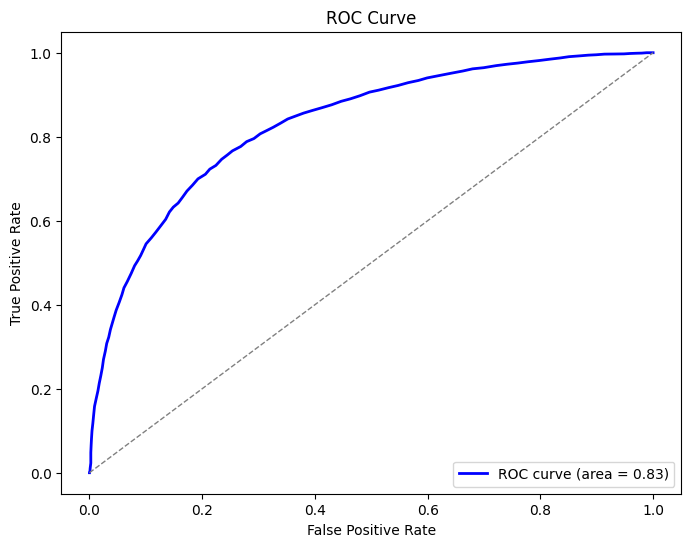

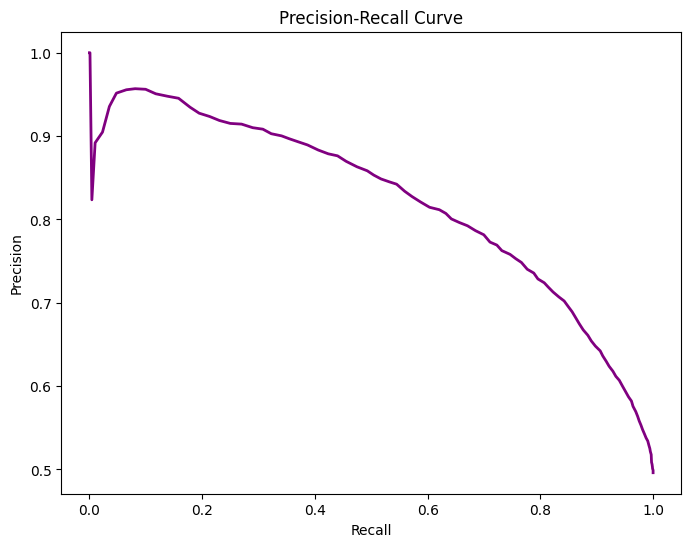

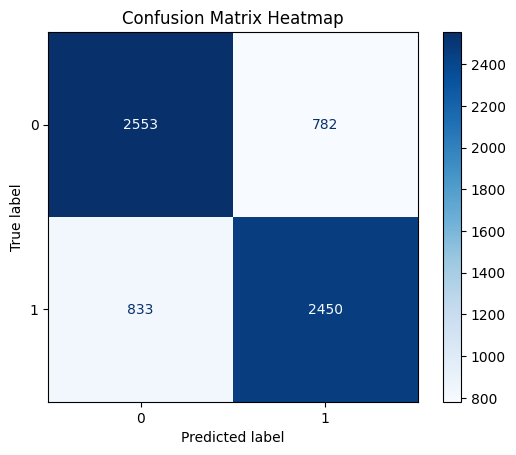

In [38]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay


# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# 3. Confusion Matrix Heatmap
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.show()